In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv"
df = pd.read_csv(url)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
# 데이터와 타겟 분리
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values


In [4]:
# 원-핫 인코딩(이진 분류이므로 생략)
#y = pd.get_dummies(y).values  #=> df일 때때
#y = to_categorical(y) # numpy 배열 일 때

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"Class {int(cls)}: {cnt} samples ({cnt / len(y_train):.2%})")

Class 0: 393 samples (64.01%)
Class 1: 221 samples (35.99%)


In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [5]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # BCEWithLogitsLoss expects (N, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [6]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [59]:
# 모델 정의
class DiabetesClassifier(nn.Module):
    def __init__(self):
        super(DiabetesClassifier, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 16)
        #self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(16, 1) # Output 하나 (로짓)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        #x = torch.relu(self.fc4(x))
        x = self.fc5(x) # sigmoid는 BCEWithLogitsLoss가 내부적으로 처리
        return x

In [60]:
# Initialize the model, loss function, and optimizer
model = DiabetesClassifier()
# pos_weight로 클래스 불균형 보정
pos_weight = torch.tensor([len(y_train) / y_train.sum() - 1])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [61]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            probs = torch.sigmoid(outputs)
            predicted = (probs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/30, Loss: 0.8772, Accuracy: 43.51%
Epoch 2/30, Loss: 0.8509, Accuracy: 66.23%
Epoch 3/30, Loss: 0.8108, Accuracy: 76.62%
Epoch 4/30, Loss: 0.7628, Accuracy: 76.62%
Epoch 5/30, Loss: 0.7185, Accuracy: 77.92%
Epoch 6/30, Loss: 0.6910, Accuracy: 79.87%
Epoch 7/30, Loss: 0.6682, Accuracy: 79.22%
Epoch 8/30, Loss: 0.6527, Accuracy: 79.22%
Epoch 9/30, Loss: 0.6507, Accuracy: 81.17%
Epoch 10/30, Loss: 0.6545, Accuracy: 79.22%
Epoch 11/30, Loss: 0.6516, Accuracy: 81.17%
Epoch 12/30, Loss: 0.6354, Accuracy: 80.52%
Epoch 13/30, Loss: 0.6335, Accuracy: 81.17%
Epoch 14/30, Loss: 0.6202, Accuracy: 79.87%
Epoch 15/30, Loss: 0.6130, Accuracy: 80.52%
Epoch 16/30, Loss: 0.6189, Accuracy: 80.52%
Epoch 17/30, Loss: 0.6140, Accuracy: 79.87%
Epoch 18/30, Loss: 0.5988, Accuracy: 79.87%
Epoch 19/30, Loss: 0.6117, Accuracy: 79.87%
Epoch 20/30, Loss: 0.6179, Accuracy: 79.22%
Epoch 21/30, Loss: 0.5963, Accuracy: 79.87%
Epoch 22/30, Loss: 0.5988, Accuracy: 80.52%
Epoch 23/30, Loss: 0.6185, Accuracy: 79.2

In [62]:
# 평가 지표 계산
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 혼동 행렬 및 평가 지표
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)

# specificity 계산
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'\nConfusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')


Confusion Matrix:
[[87 20]
 [ 9 38]]
F1 Score: 0.72
Precision: 0.66
Recall: 0.81
Specificity: 0.81


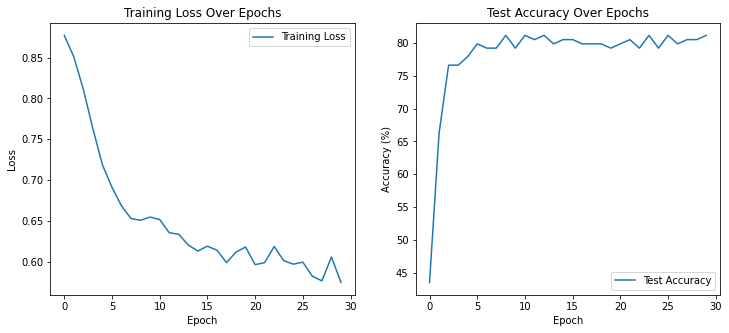

In [63]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()